In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

MNIST
Warning: fetch_mldata() is deprecated since Scikit-Learn 0.20. You should use fetch_openml() instead. However, it returns the unsorted MNIST dataset, whereas fetch_mldata() returned the dataset sorted by target (the training set and the test test were sorted separately). In general, this is fine, but if you want to get the exact same results as before, you need to sort the dataset using the following function:

In [2]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:, 1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:, 1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [3]:
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)
    mnist.target = mnist.target.astype(np.int8) # fetch_openml() returns targets as strings
    sort_by_target(mnist) # fetch_openml() returns an unsorted dataset
except ImportError:
    from sklearn.datasets import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist["data"], mnist["target"]

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [4]:
mnist.data.shape

(70000, 784)

In [5]:
X, y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

In [6]:
y.shape

(70000,)

In [7]:
28*28

784

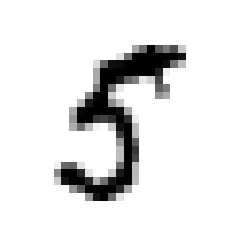

In [8]:
some_digit = X[36001]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap = mpl.cm.binary,
           interpolation="nearest")
plt.axis("off")

#save_fig("some_digit_plot")
plt.show()

In [75]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

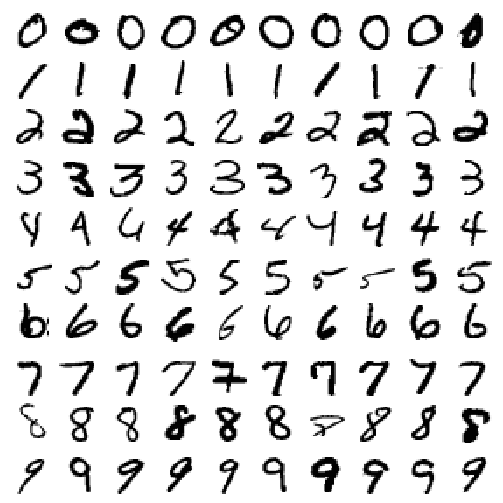

In [76]:
plt.figure(figsize=(9,9))
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
#save_fig("more_digits_plot")
plt.show()

In [9]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [10]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [11]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [12]:
y_train_5

array([False, False, False, ..., False, False, False])

In [13]:
y_test_5

array([False, False, False, ..., False, False, False])

In [14]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
              n_iter_no_change=5, n_jobs=None, penalty='l2', power_t=0.5,
              random_state=42, shuffle=True, tol=-inf, validation_fraction=0.1,
              verbose=0, warm_start=False)

In [15]:
sgd_clf.predict([some_digit])

array([ True])

In [16]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

#skfolds.split devolve n_splits subcoleccions separadas 
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    #print(train_index, test_index)
    print(n_correct / len(y_pred))

0.9686
0.96205
0.9668


In [17]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.96225, 0.9645 , 0.94765])

In [18]:
#clasificator that gives zero for every instance
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [19]:
print(np.zeros((len(X), 1), dtype=bool))

[[False]
 [False]
 [False]
 ...
 [False]
 [False]
 [False]]


In [20]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.909  , 0.90715, 0.9128 ])

In [21]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [22]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53417,  1162],
       [ 1350,  4071]])

In [23]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.7779476399770686

In [24]:
recall_score(y_train_5, y_train_pred)

0.7509684560044272

In [25]:
y_train_pred_never_5 = cross_val_predict(never_5_clf, X_train, y_train_5, cv=3)
#print(y_train_pred_never_5clf)
confusion_matrix(y_train_5, y_train_pred_never_5)
#precision_score(y_train_5, y_train_pred_never_5clf)

array([[54579,     0],
       [ 5421,     0]])

In [26]:
precision_score(y_train_5, y_train_pred_never_5)

/usr/local/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [27]:
recall_score(y_train_5, y_train_pred_never_5)

0.0

In [28]:
import math
significance= confusion_matrix(y_train_5, y_train_pred)[1,1]/math.sqrt(confusion_matrix(y_train_5, y_train_pred)[1,1]+confusion_matrix(y_train_5, y_train_pred)[0,1])
print(significance)

56.276325771559094


In [29]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7642200112633752

In [30]:
#Recorda que some_digit e o numero (a instancia) que escolleches ao primeiro de todo...
#print(some_digit)
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([116244.3686393])

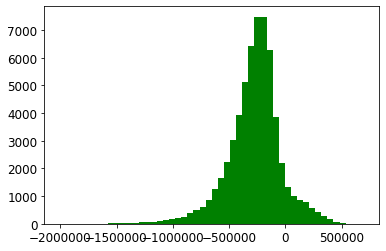

In [31]:
#print(X_train)
y_scores_train = sgd_clf.decision_function(X_train)
#print(y_scores)
import matplotlib.pyplot as plt
#n, bins, patches = plt.hist(y_scores, 50, density=True, facecolor='g', alpha=0.75)
plt.hist(y_scores_train, 50, facecolor='g')
#plt.plot(y_scores)
plt.show()

In [32]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)

In [33]:
y_some_digit_pred

array([ True])

In [34]:
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

In [35]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

In [36]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

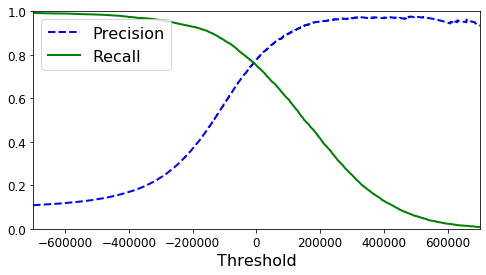

In [37]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000])
#save_fig("precision_recall_vs_threshold_plot")
plt.show()

In [38]:
from sklearn.metrics.ranking import _binary_clf_curve
import math

def f1_significance_curve(y_true, probas_pred, pos_label=None,
                           sample_weight=None):
    
    fps, tps, thresholds = _binary_clf_curve(y_true, probas_pred,
                                             pos_label=pos_label,
                                             sample_weight=sample_weight)

    precision = tps / (tps + fps)
    precision[np.isnan(precision)] = 0
    # tps[-1] is the last tps where no false negatives are expected... hence... the number of signal events
    recall = tps / tps[-1]
    f1 = 2.*(precision*recall)/(precision+recall)
    significance = tps / np.sqrt(tps + fps)
    #significance = tps / (tps + fps)
    #significance = precision/recall

    # stop when full recall attained
    # and reverse the outputs so recall is decreasing
    last_ind = tps.searchsorted(tps[-1])
    sl = slice(last_ind, None, -1)
    return np.r_[f1[sl], 1], np.r_[significance[sl], 1], thresholds[sl]

/usr/local/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.ranking module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


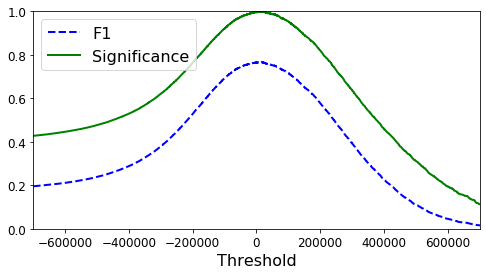

In [39]:
f1, significance, thresholds = f1_significance_curve(y_train_5, y_scores)
#print(significance)
def plot_f1_significance_vs_threshold(f1, significance, thresholds):
    plt.plot(thresholds, f1[:-1], "b--", label="F1", linewidth=2)
    plt.plot(thresholds, significance[:-1], "g-", label="Significance", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_f1_significance_vs_threshold(f1, significance/np.amax(significance) , thresholds)
#plot_f1_significance_vs_threshold(f1, significance , thresholds)
plt.xlim([-700000, 700000])
#save_fig("precision_recall_vs_threshold_plot")
plt.show()

In [40]:
thresholds[np.argmax(significance)]

14659.518486399811

In [41]:
thresholds[np.argmax(f1[0:len(f1)-1])]

14659.518486399811

In [42]:
f1[np.argmax(f1[0:len(f1)-5])]

0.7661422642602065

In [44]:
significance

array([22.20230123, 22.1983918 , 22.19857798, ...,  1.41421356,
        1.        ,  1.        ])

If we want a classifier with 90% prediction accuracy...

In [45]:
y_train_pred_90 = (y_scores > 70000)

In [46]:
precision_score(y_train_5, y_train_pred_90)

0.8712083540527101

However its recall can be very low...

In [47]:
recall_score(y_train_5, y_train_pred_90)

0.6463752075262866

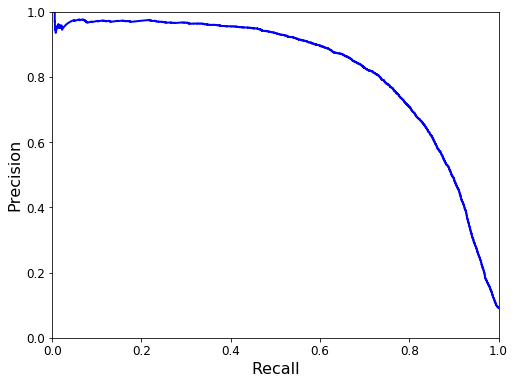

In [48]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
#save_fig("precision_vs_recall_plot")
plt.show()

# ROC curves

In [49]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

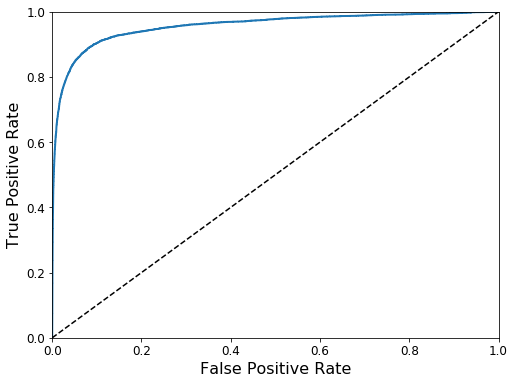

In [50]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)

plt.figure(figsize=(8, 6))
plot_roc_curve(fpr, tpr)
#save_fig("roc_curve_plot")
plt.show()

In [51]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9562435587387078

#### Note: we set n_estimators=10 to avoid a warning about the fact that its default value will be set to 100 in Scikit-Learn 0.22.

In [52]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=10, random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                    method="predict_proba")

In [53]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5,y_scores_forest)

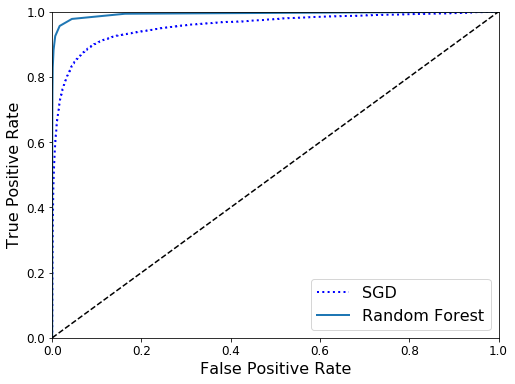

In [54]:
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, "b:", linewidth=2, label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right", fontsize=16)
#save_fig("roc_curve_comparison_plot")
plt.show()

# Vese que este método é moito máis sofisticado. Tarda máis en computar.

In [55]:
roc_auc_score(y_train_5, y_scores_forest)

0.9931243366003829

In [56]:
y_train_pred_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3)
precision_score(y_train_5, y_train_pred_forest)

0.9852973447443494

In [57]:
recall_score(y_train_5, y_train_pred_forest)

0.8282604685482383

# Multiclass classification

In [58]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([5], dtype=int8)

In [59]:
some_digit_scores = sgd_clf.decision_function([some_digit])
some_digit_scores

array([[-231441.78966675, -349392.84645986, -460822.0111683 ,
        -196490.80760676, -351109.80557074,   83413.90488382,
        -639448.37434477, -536337.429074  ,  -67976.42872115,
        -382599.37575224]])

In [60]:
np.argmax(some_digit_scores)

5

In [61]:
sgd_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int8)

When a classifier is trained, it stores the list of target classes in its classes_ attribute, ordered by value. In this case, the index of each class in the classes_ array conveniently matches the class itself (e.g., the class at index 5 happens to be class 5), but in general you won’t be so lucky.

In [62]:
sgd_clf.classes_[5]

5

In [63]:
from sklearn.multiclass import OneVsOneClassifier
ovo_clf = OneVsOneClassifier(SGDClassifier(max_iter=5, tol=-np.infty, random_state=42))
ovo_clf.fit(X_train, y_train)
ovo_clf.predict([some_digit])

array([5], dtype=int8)

In [64]:
len(ovo_clf.estimators_)

45

In [65]:
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([5], dtype=int8)

In [66]:
forest_clf.predict_proba([some_digit])

array([[0.1, 0. , 0. , 0. , 0. , 0.9, 0. , 0. , 0. , 0. ]])

In [67]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([0.8618, 0.8675, 0.8389])

In [68]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([0.9091 , 0.90955, 0.9062 ])

In [69]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5728,    3,   18,   10,   11,   48,   54,   10,   38,    3],
       [   2, 6472,   43,   27,    6,   41,    6,    9,  124,   12],
       [  59,   39, 5300,  103,   96,   24,   99,   57,  167,   14],
       [  60,   42,  133, 5357,    4,  213,   35,   52,  135,  100],
       [  14,   28,   33,    9, 5366,    8,   56,   33,   88,  207],
       [  68,   49,   30,  197,   76, 4566,  118,   33,  190,   94],
       [  35,   28,   31,    1,   47,   86, 5639,    9,   42,    0],
       [  22,   20,   70,   29,   65,   11,    6, 5789,   18,  235],
       [  55,  158,   63,  157,   11,  155,   61,   24, 5022,  145],
       [  38,   37,   30,   85,  185,   24,    2,  216,   74, 5258]])

In [70]:
def plot_confusion_matrix(matrix):
    """If you prefer color and a colorbar"""
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111)
    cax = ax.matshow(matrix)
    fig.colorbar(cax)

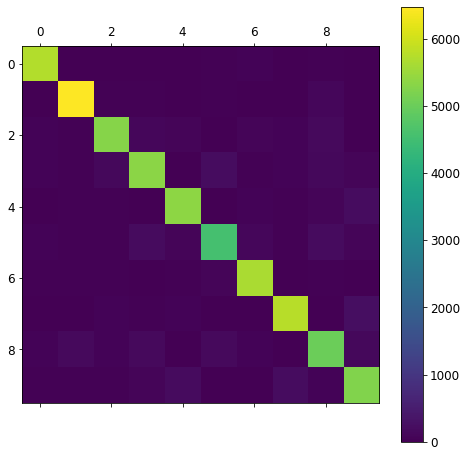

In [71]:
plot_confusion_matrix(conf_mx)

To obtain error rates: divide each value in the confusion matrix by the number of images in the corresponding class

In [72]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

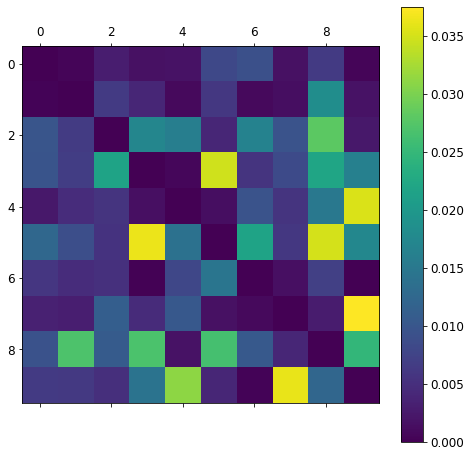

In [73]:
np.fill_diagonal(norm_conf_mx, 0)
plot_confusion_matrix(norm_conf_mx)

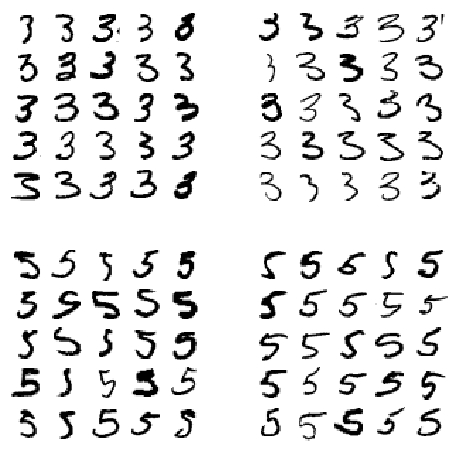

In [77]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5)
#save_fig("error_analysis_digits_plot")
plt.show()

# Multilabel Classification
## A classification according to wether a digit is large and/or odd... 

In [79]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = (y_train >= 7)
y_train_odd = (y_train % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [80]:
knn_clf.predict([some_digit])

array([[False,  True]])

## Scoring a mulilabel classification with f1 method:

In [82]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3, n_jobs=-1)
f1_score(y_multilabel, y_train_knn_pred, average="macro")

0.97709078477525

## Multioutput classification

In [83]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [85]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

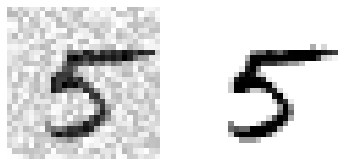

In [86]:
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])
#save_fig("noisy_digit_example_plot")
plt.show()

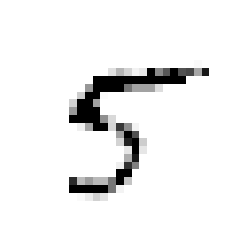

In [87]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)
#save_fig("cleaned_digit_example_plot")